In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm
import numpy as np
from scipy.stats import nbinom
import scipy.stats as stats
from scipy.special import gamma
import pandas as pd
import random
from math import comb
import math
from pickle import dump
from tqdm import tqdm
from pickle import load
from tqdm import tqdm

# Figure Generation

## Parameter Plots

In [18]:
tau = [11e-4,7e-4,5e-4,4.3671875e-4,2.5e-4]
eps = [3.525e-5,4.96875e-5,6.390625e-5,6.125e-5,1.0875e-4]

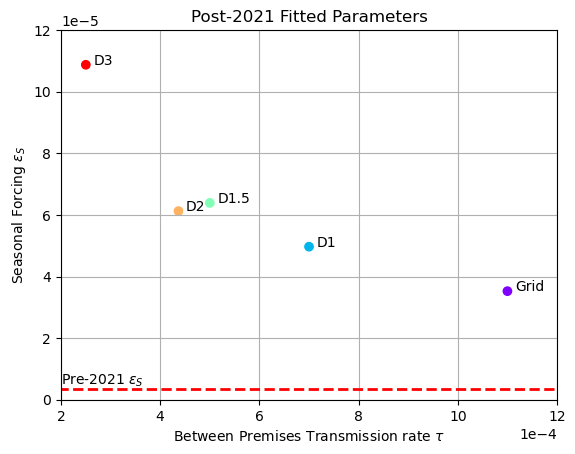

In [47]:
fig, ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(tau)))
ax.scatter(tau, eps,c = colors)
n = ["Grid","D1","D1.5","D2","D3"]
for i, txt in enumerate(n):
    ax.annotate(txt, (tau[i]+1.5e-5, eps[i]))
    
ax.ticklabel_format( axis='x', style='sci',scilimits=(-4,-4))
ax.ticklabel_format( axis='y', style='sci',scilimits=(-5,-5))

ax.set_xlim(2e-4,12e-4)
ax.set_ylim(0e-5,12e-5)

ax.set_xlabel(r'Between Premises Transmission rate $\tau$')
ax.set_ylabel(r'Seasonal Forcing $\varepsilon_S$')
ax.set_title("Post-2021 Fitted Parameters")

ax.grid()

ax.hlines(y=3.326e-6, xmin=0, xmax=20, linewidth=2, color='r', linestyles = "dashed")
ax.annotate(r"Pre-2021 $\varepsilon_S$" , (2e-4, 5e-6))

plt.savefig("images//para_plot.png",dpi = 500)

## Final Size Histograms

In [51]:
networks= ['grid','D1','D15','D2','D3']

In [233]:
final_size_data = {x:{"pre2021":[],"post2021":[]} for x in networks}

In [234]:
for net_type in tqdm(networks):
    if net_type == "grid":
        for period in list(final_size_data[net_type].keys()):
            for RNG_ID in range(1,101,1):
                for pop_ID in range(1,11,1):
                    filename = "sim_" + net_type + "_" + period + "_RNG" + str(RNG_ID).rjust(3,"0") + "_pop" + str(pop_ID).rjust(3,"0") + ".pkl"
                    with open("simulations\\"+filename,"rb") as f:
                        sim = load(f)
                    final_size_data[net_type][period].append(sim[1])
    else:
        for period in ["pre2021"]:#list(final_size_data[net_type].keys()):
            for net_ID in range(1,11,1):
                for RNG_ID in range(1,11,1):
                    for pop_ID in range(1,11,1):
                        filename = "sim_" + net_type + "_" + period + "_network" + str(net_ID).rjust(3,"0") + "_RNG" + str(RNG_ID).rjust(3,"0") + "_pop" + str(pop_ID).rjust(3,"0") + ".pkl"
                        with open("simulations\\"+filename,"rb") as f:
                            sim = load(f)
                        final_size_data[net_type][period].append(sim[1])
        
            
            
            

100%|██████████| 5/5 [00:00<00:00, 10.25it/s]


In [235]:
non_zero = [sum(x.values()) for x in final_size_data["D2"]["pre2021"] if x["N2N"]>0]

In [236]:
sum(non_zero)/len(non_zero)

15.704225352112676

In [237]:
for n in networks:
    print(len(final_size_data[n]["pre2021"]))

1000
1000
1000
1000
1000


84
5.482
134
4.769
157
3.157
135
3.276
148
3.173
84
5.482
134
4.769
157
3.157
135
3.276
148
3.173


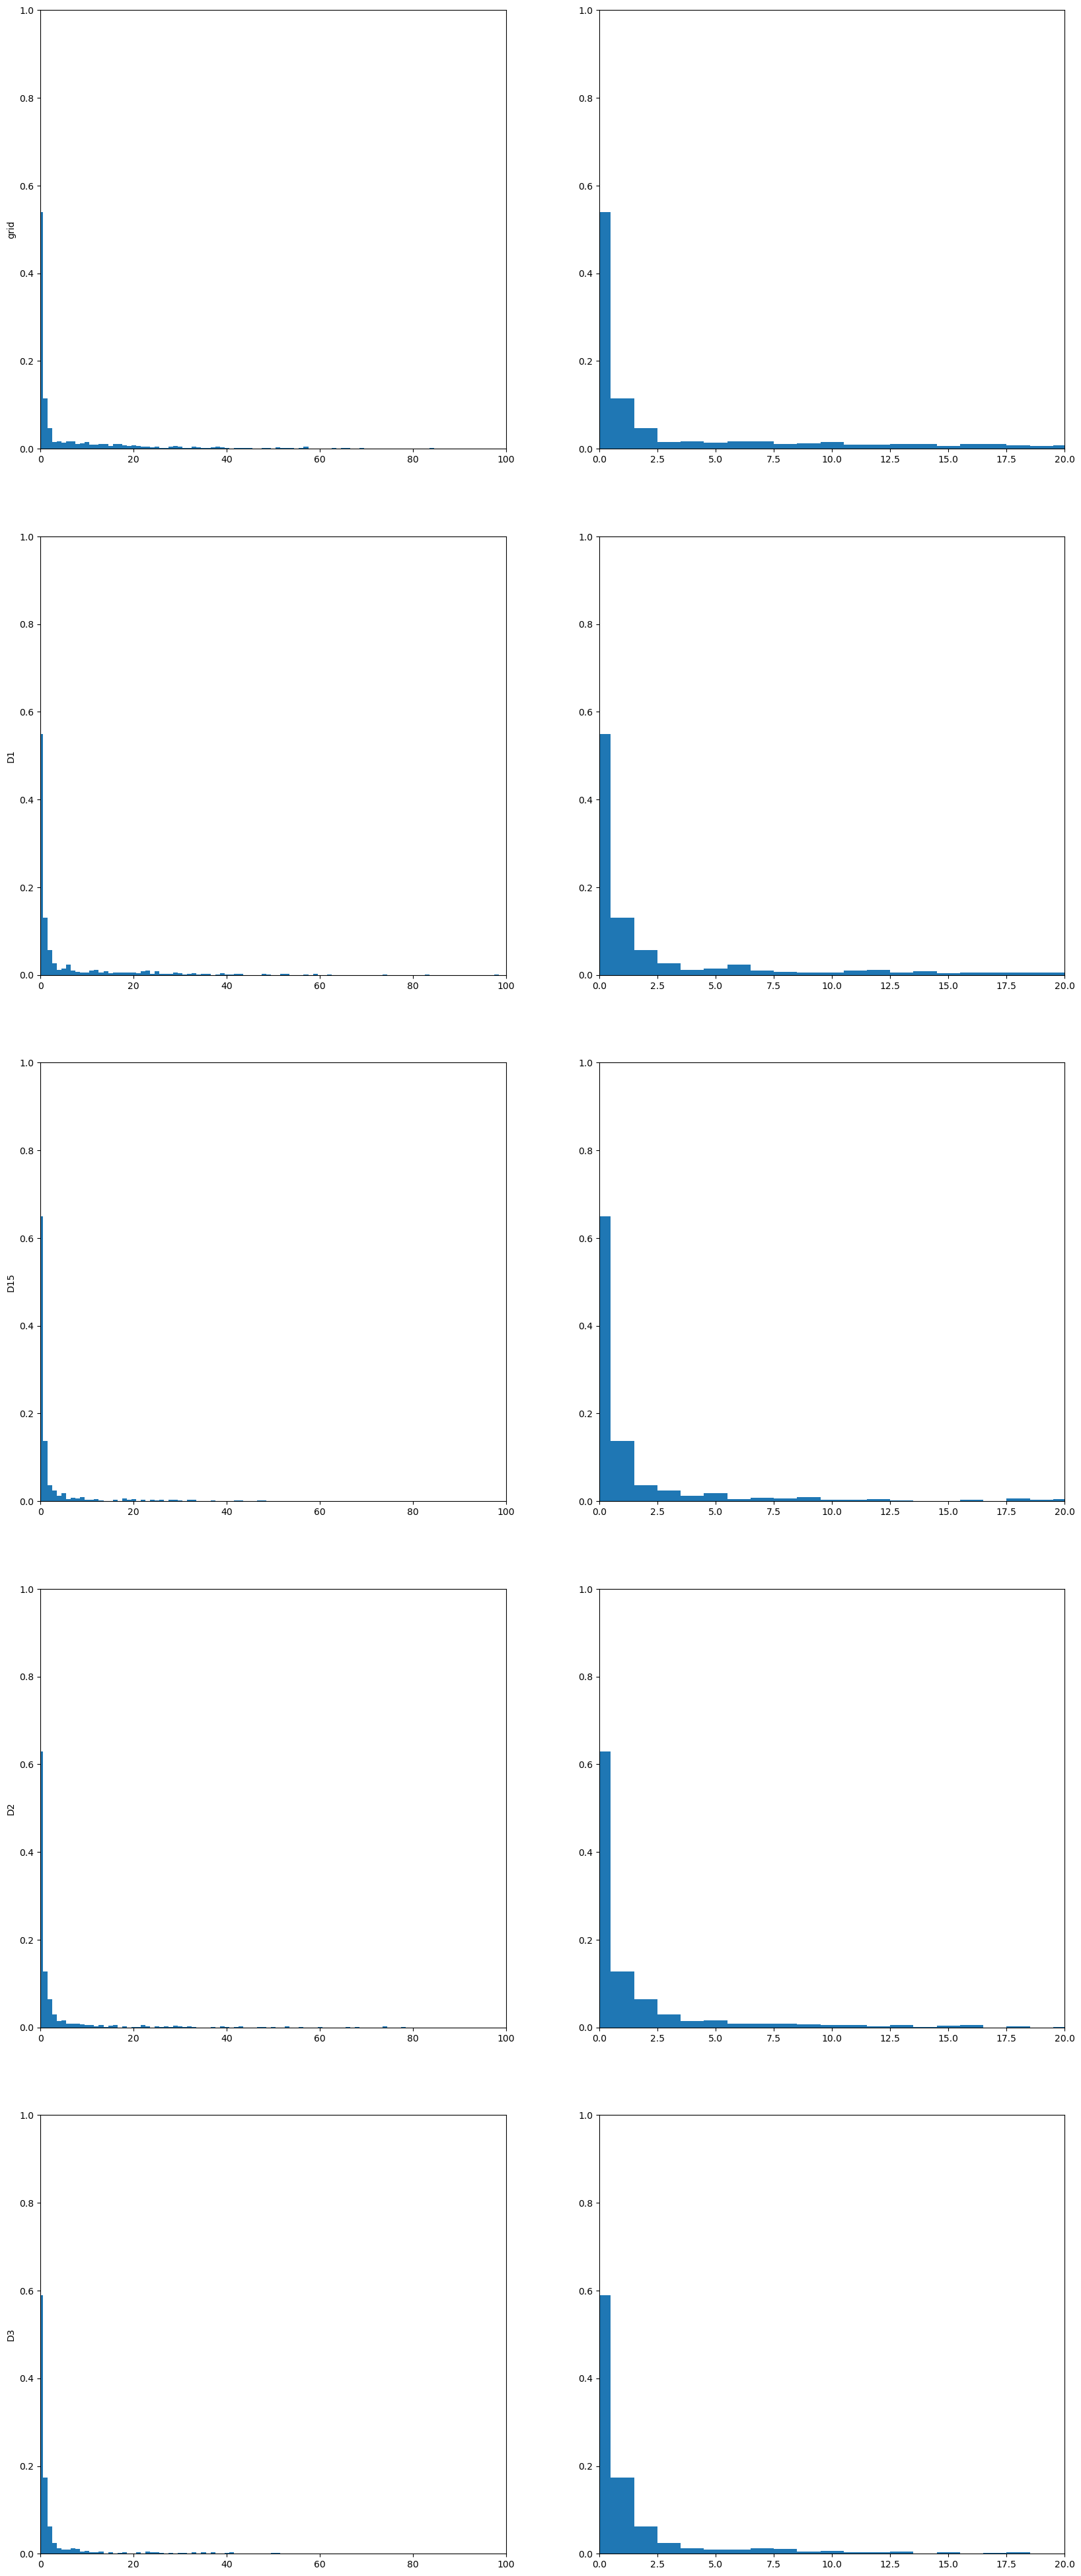

In [248]:
fig, ax = plt.subplots(5,2,figsize = (20,50))
bins = [x-0.5 for x in range(0,350,1)]
for i in range(2):
    period = list(final_size_data[net_type].keys())[0]
    for j in range(5):
        net = networks[j]
        data = [sum(x.values()) for x in final_size_data[net][period]]
        ax[j][i].hist(np.array(data),bins,density=True)
        print(max(data))
        print(sum([x for x in data if x>2])/len([x for x in data if x>-1]))
        
        if i == 0:
            ax[j][i].set_ylabel(net)
            ax[j][i].set_xlim([0,100])
            ax[j][i].set_ylim([0,1])
            
        if i == 1:
            ax[j][i].set_xlim([0,20])
            ax[j][i].set_ylim([0,1])

In [17]:
final_size_D1_pre2021 = []

In [19]:
for net_ID in tqdm(range(1,11,1)):
    for rng_ID in range(1,11,1):
        for pop_ID in range(1,11,1):
            sim_filename = "simulations\\sim_D1_pre2021_network" + str(net_ID).rjust(3,"0") + "_RNG" + str(rng_ID).rjust(3,"0") + "_pop" + str(pop_ID).rjust(3,"0") + ".pkl"
            with open((sim_filename), 'rb') as f4:
                sim = load(f4)
                final_size_D1_pre2021.append(sum(sim[1].values()))


100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


In [22]:
final_size_D1_pre2021_nonzero = [x for x in final_size_D1_pre2021 if x>1]

In [31]:
final_size_D1_post2021 = []

In [32]:
for net_ID in tqdm(range(1,11,1)):
    for rng_ID in range(1,11,1):
        for pop_ID in range(1,11,1):
            sim_filename = "simulations\\sim_D1_post2021_network" + str(net_ID).rjust(3,"0") + "_RNG" + str(rng_ID).rjust(3,"0") + "_pop" + str(pop_ID).rjust(3,"0") + ".pkl"
            with open((sim_filename), 'rb') as f4:
                sim = load(f4)
                final_size_D1_post2021.append(sum(sim[1].values()))


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


(0.0, 441.0)

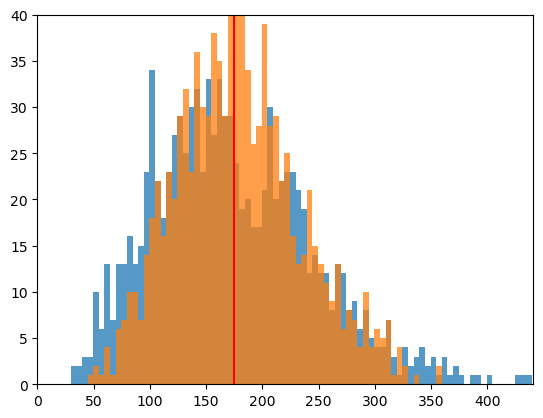

In [41]:
plt.hist(final_size_D1_post2021, bins =[x-0.5 for x in range(0,max(final_size_D1_post2021),5)],alpha = 0.75)
plt.hist(final_size_grid_post2021, bins =[x-0.5 for x in range(0,max(final_size_grid_post2021),5)], alpha = 0.75)
plt.vlines(sum(final_size_D1_post2021)/len(final_size_D1_post2021), 0, 1000, color = "r")
plt.ylim(0,40)
plt.xlim(0,max(final_size_D1_post2021))

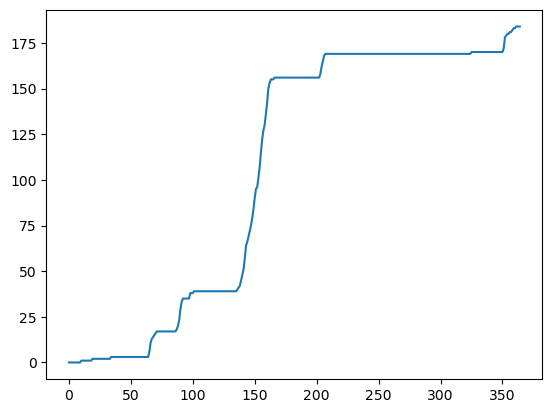